## IMAGE AUGMENTATION

* Main target is to create a network that correctly classifies the chess piece image as one of 5 classes (bishop, knight, pawn, rook, queen)
* There are less than 700 images in total, which is too small to train a deep learning network
* Augmentation can be applied to produce a larget imageset for training, and at the same time get some variability in images with sliding, flipping, blurring etc. 

### Import Necessary Modules

In [15]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import PIL
import os
import cv2
import skimage
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage.transform import resize
import re
import shutil

### Retrieve all images/labels from folders and store them in lists

In [16]:
all_images = []
labels = []
for item in ['bishop_resized', 'knight-resize', 'pawn_resized', 'Queen-Resized', 'Rook-resize', 'king-resize']:
    files = os.listdir(item)
    class_name = item.split('_')[0].split('-')[0].lower()
    print(class_name)
    for i, file in enumerate(files):
        all_images.append(plt.imread(item+'/'+file))
        labels.append(f'{class_name}-{i}')

bishop
knight
pawn
queen
rook
king


In [17]:
len(all_images), len(labels)

(588, 588)

There are 651 images in total for all classes

### Create an ImageAugmentor class that will apply various augmentations on dateset

In [18]:
#ImageAugmentor object has height&width values for the desired size of images after augmentation
class ImageAugmentor():
    def __init__(self, resize_width=400, resize_height=400): 
        self.resize_width = resize_width
        self.resize_height = resize_height
    
    #Resize image based on given h/w dimensions
    def resize_image(self, img, height, width):
        return skimage.transform.resize(img, (height, width)).astype(np.uint8)

    #Rotate the image with angle (0-360)
    def rotate_image(self, img, angle):
        return skimage.transform.rotate(img, angle=angle, mode = 'constant', preserve_range=True).astype(np.uint8)
    
    #Shift image by specified number of pixels. 
    def shift_image(self, img, shift_right, shift_down):
        num_rows, num_cols = img.shape[:2]
        # Creating a translation matrix
        translation_matrix = np.float32([ [1,0,shift_right], [0,1,shift_down] ])
        # Image translation
        return cv2.warpAffine(img, translation_matrix, (num_cols,num_rows))
    
    #Flip image on horizontal axis
    def flipLR(self, img):
        return np.fliplr(img)
    
    #Flip image on vertical axis
    def flipUD(self, img):
        return np.flipud(img)
    
    #Add random noise to the image on requested standart deviation(sigma)
    def random_noise(self, img, sigma=0.155):
        noisy = skimage.util.random_noise(img,var=sigma**2)
        return (noisy*255).astype(np.uint8)
    
    #Apply gaussian filter to return blurred image
    def blur_image(self, img, sigma=1.5):
        blurred = skimage.filters.gaussian(img,sigma=sigma, channel_axis=1)
        return (blurred*255).astype(np.uint8)
    
    #Increase brightness by adding constant value
    def brighten_image(self, img, brightness=1):
        bright = np.ones(img.shape, dtype='uint8') * brightness
        return cv2.add(img, bright)
    
    #Decrease brightness by subtracting constant value
    def darken_image(self, img, darkness=1):
        dark = np.ones(img.shape, dtype='uint8') * darkness
        return cv2.subtract(img, dark)
    
    #Zoom image by desired factor
    def zoom_image(self, img, zoom_factor=3):
        cropped = img[int(img.shape[0]/(zoom_factor*2)):-int(img.shape[0]/(zoom_factor*2)), int(img.shape[1]/(zoom_factor*2)):-int(img.shape[1]/(zoom_factor*2)), :]
        zoomed = cv2.resize(cropped, None, fx=zoom_factor, fy=zoom_factor)
        return zoomed
    
    #Create augmented images applying above techniques together
    def create_images(self, img):
        new_images = []
        if (img.shape[0] > self.resize_width) or (img.shape[1]>self.resize_height):
            img = self.resize_image(img, self.resize_width, self.resize_height)
        for angle in [10, 30, 45, 90, 120, 140, 180, 270, 300, 360]:
            rotated = self.rotate_image(img, angle)
            lr = self.flipLR(rotated)
            ud = self.flipUD(rotated)
            for im in [rotated, lr, ud]:
                new_images.append(im)
                new_images.append(self.random_noise(im, 0.250))
                new_images.append(self.darken_image(im, 100))
                new_images.append(self.brighten_image(im, 100))
                new_images.append(self.resize_image(self.zoom_image(im, 3), im.shape[0], im.shape[1]))
                new_images.append(self.blur_image(im))
                new_images.append(self.shift_image(im, 50, 30))
                new_images.append(self.shift_image(im, -50, 30))
        return new_images

### Create augmented images and save in separate folders

In [19]:
os.mkdir('dataset')

In [20]:
augmentor = ImageAugmentor()
# for i in range(1, 651):
current_class = 'bishop'
print(f'bishop augmentation started!')
for image, label in zip(all_images, labels):
    cls = label.split("-")[0]
    if cls not in os.listdir('dataset'):
        os.mkdir(f'dataset/{cls}')
    if current_class != cls:
        print(f'{cls} augmentation started!')
        current_class = cls
    
    # repeat augmentation for king
    if (current_class == 'king'):
        #3x more augments
        for x in range(4):
            augmented_images = augmentor.create_images(image)
            for i,img in enumerate(augmented_images):
                cv2.imwrite(f'dataset/{cls}/{i*x+1}-{label}.png', img)

    # normal augmentation
    else:           
        augmented_images = augmentor.create_images(image)
        for i,img in enumerate(augmented_images):
            cv2.imwrite(f'dataset/{cls}/{i+1}-{label}.png', img)

bishop augmentation started!


KeyboardInterrupt: 

In [ ]:
image_count = 0
for folder in os.listdir('dataset'):
    for item in os.listdir(f'dataset/{folder}'):
        image_count += 1
print(f'Total # images after augmentation = {image_count}')

Total # images after augmentation = 156960


### Augmented Samples

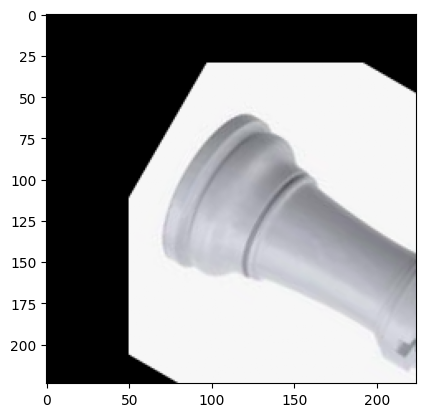

In [ ]:
im = plt.imread(f'dataset/rook/{os.listdir("dataset/rook")[1325]}')
plt.imshow(im)

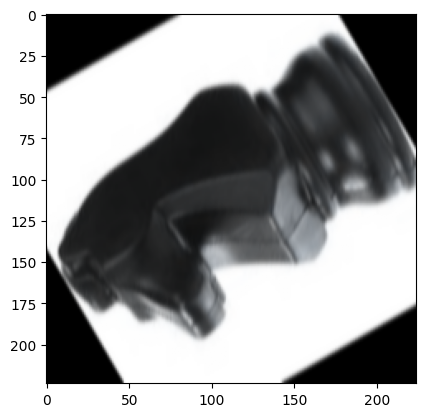

In [ ]:
im = plt.imread(f'dataset/knight/{os.listdir("dataset/knight")[825]}')
plt.imshow(im)